In [1]:
import pickle
import numpy as np
from sklearn.cluster import KMeans
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import cv2
from matplotlib import pyplot as plt
import colorsys
from sklearn.cluster import KMeans, MeanShift, DBSCAN, AgglomerativeClustering
from sklearn import metrics


In [2]:
def load_dataset():
  image_pickle_file_path = 'images.pkl'
  label_pickle_file_path = 'label.pkl'

  with open(image_pickle_file_path, 'rb') as file:
    images = pickle.load(file)

  with open(label_pickle_file_path, 'rb') as file:
    labels = pickle.load(file)

  images = images.reshape(images.shape[0], -1)

  return images, labels

In [3]:
images, labels = load_dataset()

In [14]:
# nthImageToRGB function converts the nth image from an array into the RGB format
def arrayToRGB(image):
    imageWith3Channels = image.reshape(499,499,3)
#     plt.imshow(imageWith3Channels)
#     plt.axis('off')  # Turn off axis labels
#     plt.show()
    return imageWith3Channels

In [57]:
def nthImageRGBToHSV(image):
    hsvImage = cv2.cvtColor(arrayToRGB(image), cv2.COLOR_BGR2HSV)
#     cv2.imshow('HSV image', hsvImage)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    return hsvImage


In [58]:
def featureExtractorFromPixels(image):
    myImage = nthImageRGBToHSV(image)
    featureVectorsOfPixelsInMyImage = [] # (x,y,h,s,v,h,s,v,h,s,v) of each pixel, in a specific image
    for x in range(len(myImage)):
        for y in range(len(myImage[x])):
    #         print(x,y,myImage[x][y])
            featureVectorsOfPixelsInMyImage += [[x,y,myImage[x][y][0],myImage[x][y][1],myImage[x][y][2]]]
    return featureVectorsOfPixelsInMyImage

In [59]:
# test_size = .1
# X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=test_size, random_state=42)

In [60]:
def standardize(array):
    scaler = sk.preprocessing.StandardScaler()
    array_standardized = scaler.fit_transform(featureExtractorFromPixels(array))
    return array_standardized

In [61]:
def pixelsToRegions(image):
    cluteringAlgo = KMeans(n_clusters=30)
    # standardization
    image_standardized = standardize(image)
        # Fit the model and predict clusters
    predictedLabels = cluteringAlgo.fit_predict(image_standardized)
    return predictedLabels

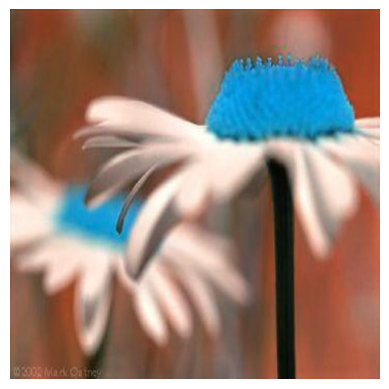

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


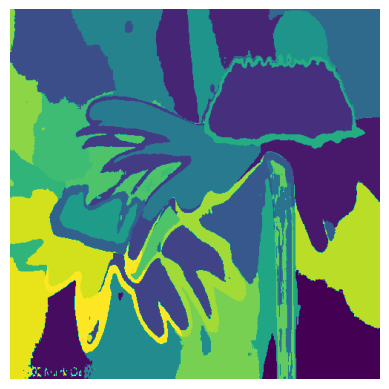

In [62]:
myImage = images[300]
plt.imshow(arrayToRGB(myImage))
plt.axis('off')  # Turn off axis labels
plt.show()

plt.imshow(pixelsToRegions(myImage).reshape(499,499))
plt.axis('off')  # Turn off axis labels
plt.show()

In [113]:
import warnings
warnings.simplefilter("ignore")
    
sum_calinski_harabasz_score = 0
for image in images:
    sum_calinski_harabasz_score += metrics.calinski_harabasz_score(standardize(image), pixelsToRegions(image))
    print("|",end="")
print("average calinski_harabasz_score: ",sum_calinski_harabasz_score/len(images))

warnings.simplefilter("default")


average calinski_harabasz_score:  148655.62


In [115]:
import warnings
warnings.simplefilter("ignore")

sum_davies_bouldin_score = 0
for image in images:
    sum_davies_bouldin_score += metrics.davies_bouldin_score(standardize(image), pixelsToRegions(image))
    print("|",end="")

warnings.simplefilter("default")

print("average sum_davies_bouldin_score: ",sum_davies_bouldin_score/len(images))


average sum_davies_bouldin_score:  1.1339536887598354


In [116]:
# predictions => predictedRegionForEachPixel
def regionBasedFeatureVectorGenerator(image,predictions):
    # for every region do
    allRegionBasedFeaturesOfAnImage = []
    for i in range(max(predictions)+1):
        pixelLevelFeaturesOfAnImage = np.array(featureExtractorFromPixels(image))
        # perform masking; select those regions clustered as 0, 1, 2, ... separately, and create a regionLevel feature
        # vector for each region
        ithRegionPixelLevelFeatures = pixelLevelFeaturesOfAnImage[predictions==i]
        # selecting h,s,v
        HSVColumns = ithRegionPixelLevelFeatures[:,2:5]
        averageHSVColumns = np.mean(HSVColumns,axis=0)
        stdHSVColumns = np.std(HSVColumns,axis=0)
        numberOfPixelsInThisRegion = len(ithRegionPixelLevelFeatures)
        XYColumns = ithRegionPixelLevelFeatures[:,0:2]
        averageXYColumns = np.mean(XYColumns,axis=0)
        stdXYColumns = np.std(XYColumns,axis=0)
        # concat different features to make a vector
        # averageXYColumns -> avg x, avg y
        # stdXYColumns -> std x, std y
        # numberOfPixelsInThisRegion -> int
        # averageHSVColumns -> avg h, avg s, avg v
        # stdHSVColumns -> std h, std s, std v
        ithRegionFeatureVector = np.hstack((averageXYColumns, stdXYColumns, numberOfPixelsInThisRegion,averageHSVColumns,stdHSVColumns))
        allRegionBasedFeaturesOfAnImage += [list(ithRegionFeatureVector)]
    return allRegionBasedFeaturesOfAnImage

# regionPredictionForEachPixel = pixelsToRegions(X_train[6])
# print(regionBasedFeatureVectorGenerator(X_train[6],regionPredictionForEachPixel))


In [64]:
AllRegionBasedFeatureVectorsPerImage = []
AllRegionBasedFeatureVectors = []
for ithImage in images:
    regionPredictionForEachPixel = pixelsToRegions(ithImage)
    regionBasedFeatureVectorsOfAnImage = regionBasedFeatureVectorGenerator(ithImage,regionPredictionForEachPixel)
    AllRegionBasedFeatureVectorsPerImage += [regionBasedFeatureVectorsOfAnImage]
    AllRegionBasedFeatureVectors += regionBasedFeatureVectorsOfAnImage

np.save('3d_array30EqualWeights.npy', AllRegionBasedFeatureVectorsPerImage)
np.save('2d_array30EqualWeights.npy', AllRegionBasedFeatureVectors)

In [4]:
array_2d = np.load('2d_array30EqualWeights.npy')
array_3d = np.load('3d_array30EqualWeights.npy')
# print(array_2d.shape)
# print(array_3d.shape)
np.unique(array_2d,axis=0).shape
#all vectors are unique

(16798, 11)

In [5]:
number_of_clusters = 150
number_of_pics = len(images)
number_of_features = 11

In [6]:
# clustering all regions of all images using K-means

scaler = sk.preprocessing.StandardScaler()
array_2dstandard = scaler.fit_transform(array_2d)

kmeans = KMeans(n_clusters=number_of_clusters,random_state=45)
kmeans_labels = kmeans.fit_predict(array_2dstandard)
kmeans_score = metrics.silhouette_score(array_2dstandard, kmeans_labels)
# Silhouette score is one way to evaluate clustering quality
print("K-Means Silhouette Score:", kmeans_score)


C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-Means Silhouette Score: 0.08947336318865447


In [7]:
hih=[]
clu1 = array_2d[kmeans_labels==1] #all regions in cluster 1
for i in clu1:
  for j in range(number_of_pics):
    if i in array_3d[j]:
      hih.append(j)

# print(hih)
# print(len(hih))
#[4, 20, 28, 31, 57, 60, 118, 20, 221, 229, 278, 296, 302, 317, 318, 333, 337, 357, 358, 376, 378, 432, 442]

In [8]:
# print(array_2d[2182],"\n",array_3d[436])

In [9]:
import numpy as np

# Reshape the 2D array to match the 3D array's shape
reshaped_array_2d = array_2d.reshape((number_of_pics, 30, number_of_features))

# Compare each row in the reshaped 2D array with the 3D array along the third dimension
matching_indices = np.where(np.all(reshaped_array_2d[:, np.newaxis, :] == array_3d, axis=-1))

# Extract the indices of matches
indices_3d = matching_indices[1]

# Reshape the indices to match the original 2D array's shape
indices_3d = indices_3d.reshape(array_2d.shape[0])

# print(indices_3d[:20])
# print(kmeans_labels[:20])


# Printing the indices for each row in the 2D array
#for i, idx in enumerate(indices_3d):
 #   print(f"Row {i} in 2D array matches at index {idx} in the 3D array's third dimension.")





In [10]:
edge = np.full(number_of_features, 1e-8)

In [11]:
region_per_image= np.zeros(shape=(number_of_pics,number_of_clusters))
for i in range(len(kmeans_labels)):
  region_per_image[indices_3d[i]][kmeans_labels[i]]+=1

# print(region_per_image[:20][:20])
row_sums = np.sum(region_per_image, axis=1)
# print(row_sums)

In [105]:
# clustering all regions of all images using MeanShift (just to check how it behaves)
# adjust bandwidth
meanshift = MeanShift(bandwidth=750)
meanshift_labels = meanshift.fit_predict(array_2d)
meanshift_unique_labels = np.unique(meanshift_labels)
num_clusters_meanshift = len(meanshift_unique_labels)
meanshift_score = metrics.silhouette_score(array_2d, meanshift_labels)
print("Number of clusters found by Mean-Shift:", num_clusters_meanshift)
print("Mean-Shift Silhouette Score:", meanshift_score)


In [106]:
# clustering all regions of all images using DBSCAN (just to check how it behaves)
# adjust parameters
dbscan = DBSCAN(eps=100, min_samples=2)
dbscan_labels = dbscan.fit_predict(array_2d)
dbscan_unique_labels = np.unique(dbscan_labels)
num_clusters_dbscan = len(dbscan_unique_labels) - 1 if -1 in dbscan_labels else len(dbscan_unique_labels)
dbscan_score = metrics.silhouette_score(array_2d, dbscan_labels)
print("Number of clusters found by DBSCAN:", num_clusters_dbscan)
print("DBSCAN Silhouette Score:", dbscan_score)


In [107]:
# clustering all regions of all images using AgglomerativeClustering (just to check how it behaves)
agglo = AgglomerativeClustering(n_clusters=100)  # Set the number of clusters
agglo_labels = agglo.fit_predict(array_2d)
agglo_score = metrics.silhouette_score(array_2d, agglo_labels)
print("Agglomerative Clustering Silhouette Score:", agglo_score)


In [12]:
# Classify the datapoints with the Random Forest Classifier

def classify(datapoints, labels):
    test_size = 0.3
    X_train, X_test, y_train, y_test = train_test_split(datapoints, labels, test_size=test_size, random_state=42)

    clf = RandomForestClassifier(n_estimators=100, random_state=42,max_depth=16)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred,average='macro')
    recall = recall_score(y_test, y_pred,average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    print("confusion_matrix\n",confusion_matrix(y_test, y_pred))
    
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}")
    print(f"Recall: {recall * 100:.2f}")
    print(f"F1_Score: {f1 * 100:.2f}")
    
    return y_pred,X_train, X_test, y_train, y_test 
y_pred,X_train, X_test, y_train, y_test  = classify(region_per_image,labels)

confusion_matrix
 [[24  0  0  1  0  0  1]
 [ 0 17  4  1  0  3  3]
 [ 0  0 20  0  0  3  1]
 [ 0  0  0 21  0  0  0]
 [ 0  0  1  2 21  0  1]
 [ 0  2  2  0  0 14  0]
 [ 3  2  1  0  1  3 16]]
Accuracy: 79.17%
Precision: 79.19
Recall: 79.95
F1_Score: 78.93


<hr><hr><hr><hr><hr><hr><hr><hr>
Frequent errors: 

The followers of class 1 were classified as 6<br>
The followers of class 6 were classified as 0<br>
The followers of class 6 were classified as 5<Br>


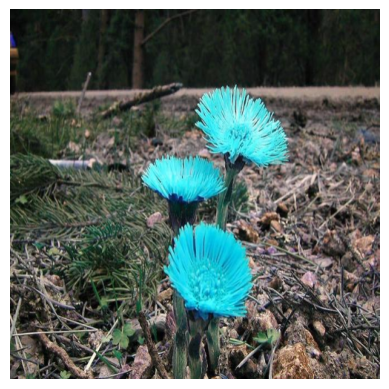

In [15]:
# label=1 , predicted 6
counter= 0
for i in region_per_image:
    if list(i)==list(X_test[np.logical_and(np.equal(y_pred,6),np.equal(y_test,1))][0]):
        break
    counter+=1
plt.imshow(arrayToRGB(images[counter]))
plt.axis('off')  # Turn off axis labels
plt.show()



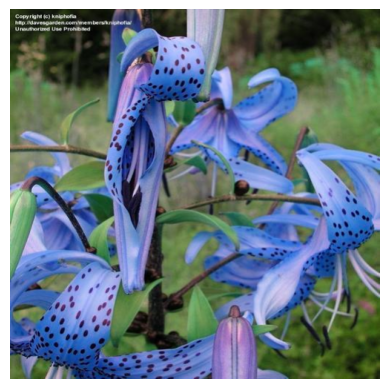

In [16]:
# label=6 , predicted 0
counter= 0
for i in region_per_image:
    if list(i)==list(X_test[np.logical_and(np.equal(y_pred,0),np.equal(y_test,6))][1]):
        break
    counter+=1
plt.imshow(arrayToRGB(images[counter]))
plt.axis('off')  # Turn off axis labels
plt.show()



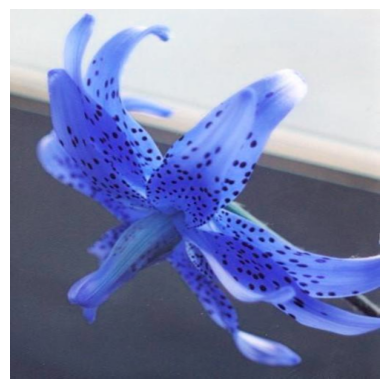

In [17]:
# label=6 , predicted 5
counter= 0
for i in region_per_image:
    if list(i)==list(X_test[np.logical_and(np.equal(y_pred,5),np.equal(y_test,6))][2]):
        break
    counter+=1
plt.imshow(arrayToRGB(images[counter]))
plt.axis('off')  # Turn off axis labels
plt.show()



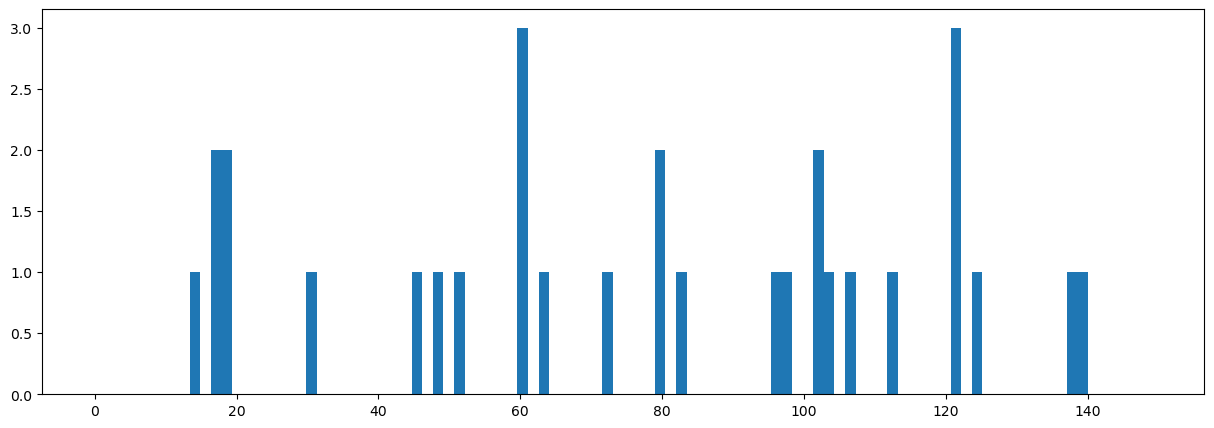

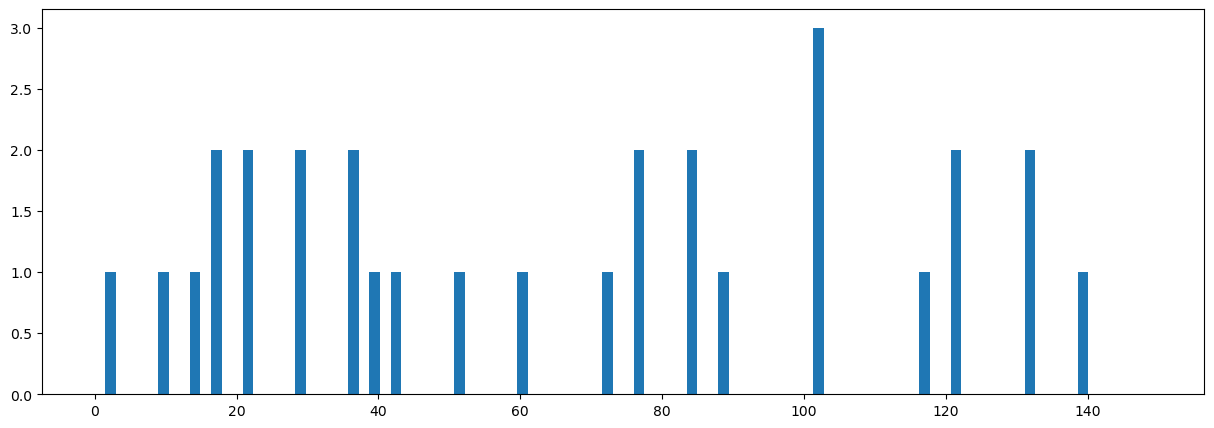

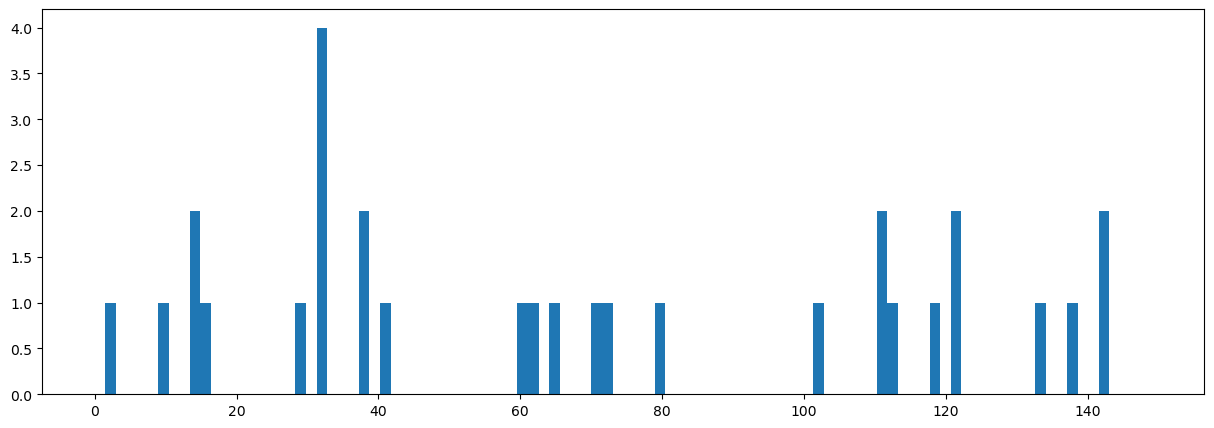

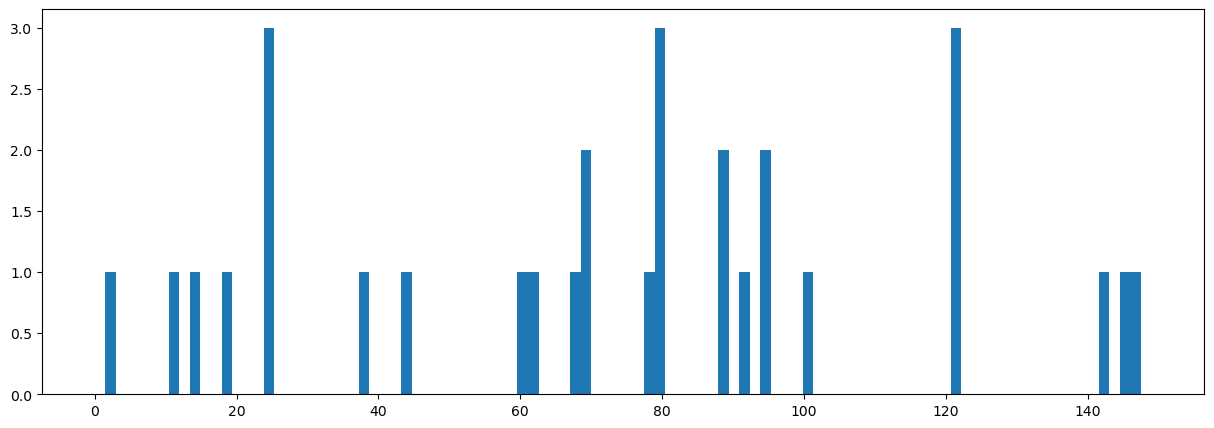

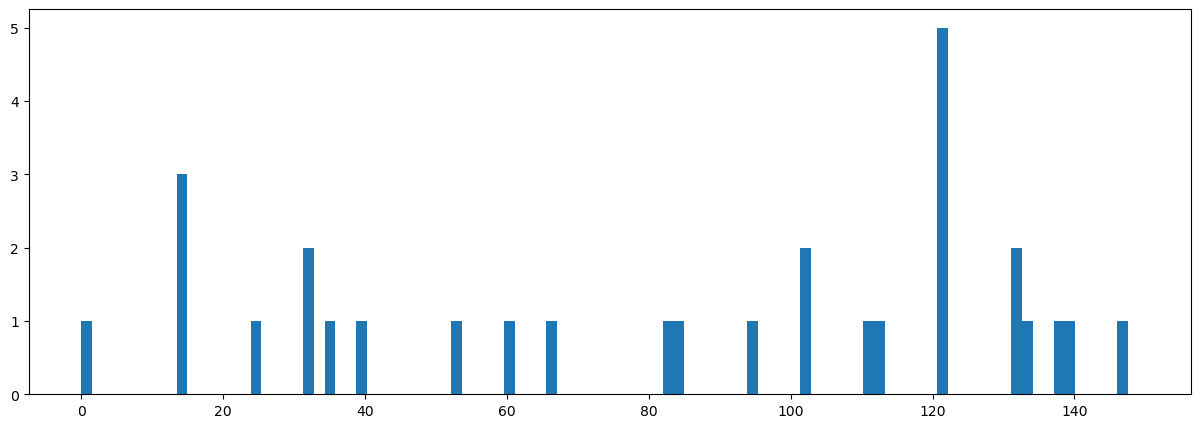

In [27]:
# plotting histograms for different images (only 5 of them)
for i in range(len(region_per_image[:5])):
    plt.figure(figsize=(15,5))
    plt.hist(range(150),bins=100,weights = region_per_image[i])
    plt.show()

In order to improve our results we can add more images to our dataset in order to overcome overfitting of Random Forest.
Also, we can add more complicated features to our feature vectors.
Due to lack of time, we could not fine-tune the hyper-parameters perfectly.
Some evaluation matrices like Silhouette Score  take a lot of time and memory to compute, and some algorithms like mean-shift are also time-consuming.



<br>
The best model was made when HSVweight = XYweight<br>
Other settings make the problem worse<br>
<h6> check the document and the images in it for this

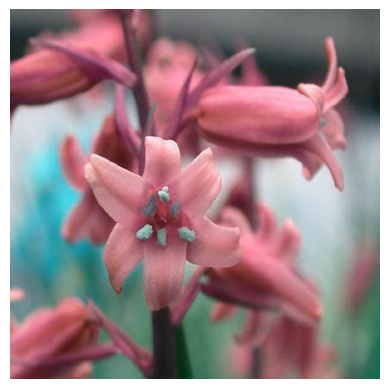

In [18]:
# draw an image with label 0
myImage = arrayToRGB(images[np.array(labels)==0][0])
plt.imshow(myImage)
plt.axis('off')  # Turn off axis labels
plt.show()

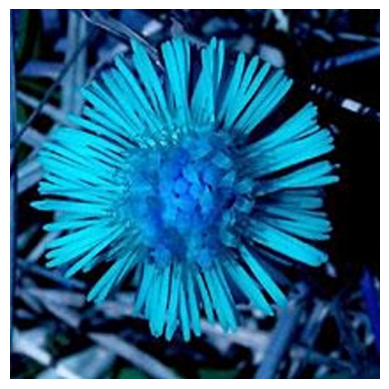

In [19]:
# draw an image with label 1
myImage = arrayToRGB(images[np.array(labels)==1][0])
plt.imshow(myImage)
plt.axis('off')  # Turn off axis labels
plt.show()

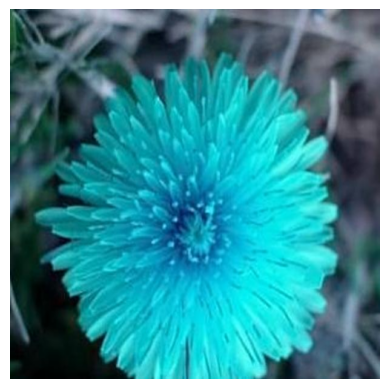

In [20]:
# draw an image with label 2
myImage = arrayToRGB(images[np.array(labels)==2][0])
plt.imshow(myImage)
plt.axis('off')  # Turn off axis labels
plt.show()

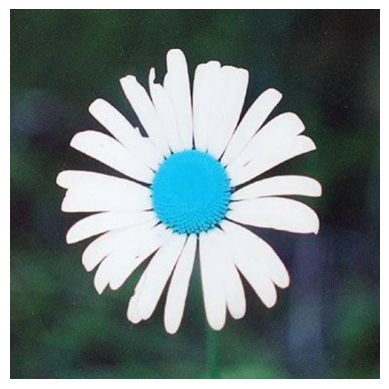

In [21]:
# draw an image with label 3
myImage = arrayToRGB(images[np.array(labels)==3][0])
plt.imshow(myImage)
plt.axis('off')  # Turn off axis labels
plt.show()

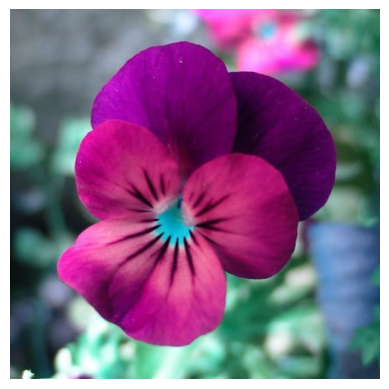

In [22]:
# draw an image with label 4
myImage = arrayToRGB(images[np.array(labels)==4][0])
plt.imshow(myImage)
plt.axis('off')  # Turn off axis labels
plt.show()

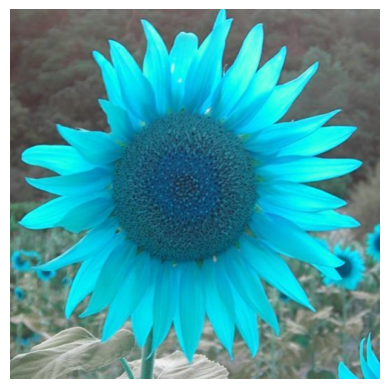

In [23]:
# draw an image with label 5
myImage = arrayToRGB(images[np.array(labels)==5][0])
plt.imshow(myImage)
plt.axis('off')  # Turn off axis labels
plt.show()

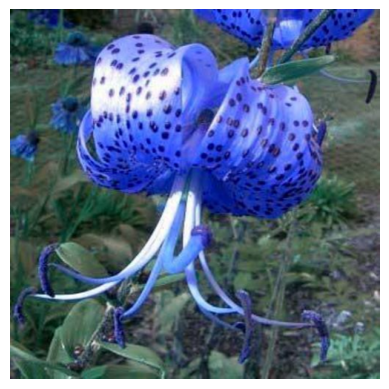

In [24]:
# draw an image with label 6
myImage = arrayToRGB(images[np.array(labels)==6][2])
plt.imshow(myImage)
plt.axis('off')  # Turn off axis labels
plt.show()